In [39]:
# import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [40]:
# download the stock data
stock_df = yf.download('TSLA', start='2015-01-01', end='2024-06-01')
stock_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


In [41]:
# set the index
pd.DataFrame.reset_index(stock_df, inplace=True)
stock_df = stock_df.drop(columns=['Date'])
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
0,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
1,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
3,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
4,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


In [42]:
# caculate the returns of stocks
returns = stock_df['Adj Close'].pct_change()
stock_df['Returns'] = returns
stock_df.dropna(inplace=True)
X = stock_df.drop('Returns', axis=1)
y = stock_df['Returns']
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
1,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,-0.042041
2,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,0.005664
3,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,-0.001562
4,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,-0.001564
5,13.928000,13.998667,13.664000,13.777333,13.777333,70024500,-0.018802


In [43]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 1. Linear Model

In [44]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

win_ratio_lr = np.mean(np.sign(y_pred_lr) == np.sign(y_test.values))

print('Linear Regression RMSE: ', rmse_lr)
print('Linear Regression Win Ratio: ', win_ratio_lr)

Linear Regression RMSE:  0.02289544292556913
Linear Regression Win Ratio:  0.820675105485232


# 2. Random Forest Regression

In [45]:
# random forest regressor
rf_model = RandomForestRegressor(random_state=666)
rf_model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(random_state=666)

In [46]:
y_rf_pred = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_rf_pred))
win_ratio_rf = np.mean(np.sign(y_rf_pred) == np.sign(y_test.values))
print('Random Forest RMSE: ', rmse_rf)
print('Random Forest Win Ratio: ', win_ratio_rf)

Random Forest RMSE:  0.03323475816591011
Random Forest Win Ratio:  0.6540084388185654


<Figure size 1000x600 with 0 Axes>

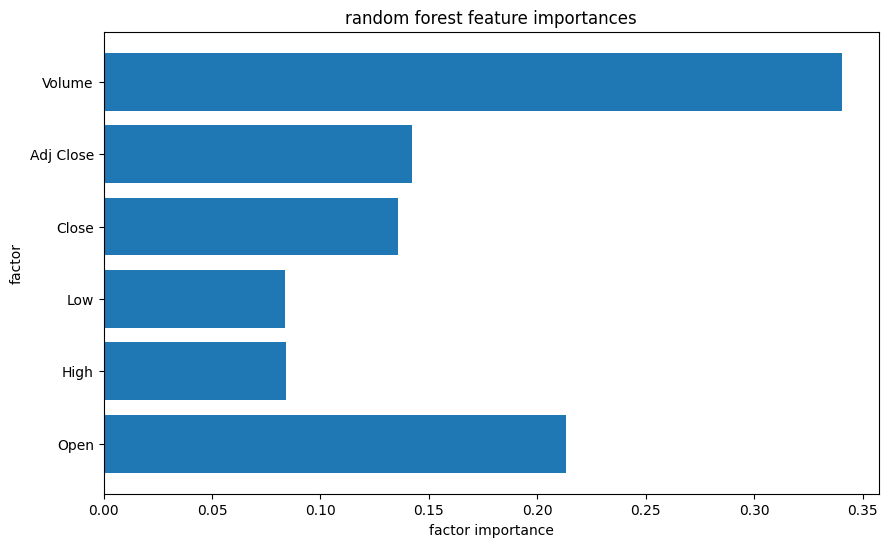

In [47]:
plt.figure(figsize=(10, 6))

feature_importances = rf_model.feature_importances_

# Plotting feature importances for visualization
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('factor importance')
plt.ylabel('factor')
plt.title('random forest feature importances')
plt.show()

In [48]:
parameters = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}

rf_grid = GridSearchCV(rf_model, parameters, cv=3)
rf_grid.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=666),
             param_grid={'max_depth': [10, 20], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [49]:
y_rf_grid_pred = rf_grid.predict(X_test)

In [50]:
# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(rf_grid.best_params_))
print("Best score is {}".format(rf_grid.best_score_))
print("Random Forest GRID RMSE: ", np.sqrt(mean_squared_error(y_test, rf_grid.predict(X_test))))
print("Random Forest GRID Win Ratio: ", np.mean(np.sign(rf_grid.predict(X_test)) == np.sign(y_test.values)))

Tuned Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best score is 0.04135590650377726
Random Forest GRID RMSE:  0.03266526180668079
Random Forest GRID Win Ratio:  0.6181434599156118


<span style="color: red;">**It is amazing!**</span>

The random forest which is complex is not as good as the linear model.

It must be the data is still to small to make a good prediction.We did not get enough effective factors to predict the stock prices.

# 3. XGBoost

In [51]:
# XGBoost
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
win_ratio_xgb = np.mean(np.sign(y_pred_xgb) == np.sign(y_test.values))

In [52]:
print("Linear Regression - RMSE:", rmse_lr, "Win Ratio:", win_ratio_lr)
print("Random Forest - RMSE:", rmse_rf, "Win Ratio:", win_ratio_rf)
print("XGBoost - RMSE:", rmse_xgb, "Win Ratio:", win_ratio_xgb)

Linear Regression - RMSE: 0.02289544292556913 Win Ratio: 0.820675105485232
Random Forest - RMSE: 0.03323475816591011 Win Ratio: 0.6540084388185654
XGBoost - RMSE: 0.03283453793473983 Win Ratio: 0.6413502109704642


We can see that the Linear Regression model has a good fit to the data.    : (


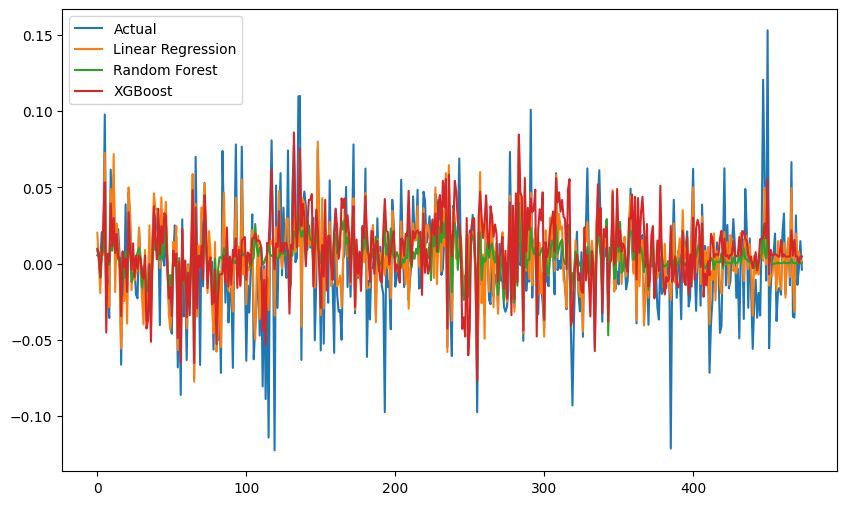

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lr, label='Linear Regression')
plt.plot(y_rf_grid_pred, label='Random Forest')
plt.plot(y_pred_xgb, label='XGBoost')
plt.legend()
plt.show()

Conclusion:
1. Random forest seems to shy to shake
2. Though XGBoost shake severely, its fitness is not as good as Linear Model.
3. We need more data and factors to show the strength of complex models.

apply the code to big7

In [54]:
risky_asset = ['TSLA', 'AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META']
for asset in risky_asset:
    stock_data = yf.download(asset, start='2016-01-01', end='2024-05-28')
    returns = stock_df['Adj Close'].pct_change()
    stock_df['Returns'] = returns
    stock_df.dropna(inplace=True)
    X = stock_df.drop('Returns', axis=1)
    y = stock_df['Returns']
    X_train, X_test, y_train, y_test = X[:1690], X[1690:], y[:1690], y[1690:]
    rf_model = RandomForestRegressor(random_state=666)
    rf_model.fit(X_train, y_train.values.ravel())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [55]:
stock_data = yf.download('TSLA', start='2016-01-01', end='2024-05-28')
X = stock_data.pct_change()
X.dropna(inplace=True)
X[1690:]

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-21,0.004496,0.001500,-0.016199,-0.025686,-0.025686,0.014810
2022-09-22,-0.027344,-0.039866,-0.049263,-0.040592,-0.040592,0.127721
2022-09-23,-0.055926,-0.055727,-0.045483,-0.045948,-0.045948,-0.096349
2022-09-26,-0.039775,-0.001441,-0.009200,0.002470,0.002470,-0.088967
2022-09-27,0.044182,0.016122,0.026636,0.025108,0.025108,0.066262
...,...,...,...,...,...,...
2024-05-20,0.023106,-0.010466,0.004457,-0.014144,-0.014144,-0.202960
2024-05-21,-0.011545,0.051364,0.006858,0.066591,0.066591,0.867347
2024-05-22,0.041821,-0.016481,0.019518,-0.034780,-0.034780,-0.233832
